In [1]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, accuracy_score, plot_roc_curve, plot_confusion_matrix, roc_curve, confusion_matrix
import itertools
from tensorflow.keras.initializers import Constant, TruncatedNormal
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from numpy import mean, absolute

# Oversampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

Dataset wird ausbalanciert

Balance Out Dataset

In [2]:
n = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]

for i in n:
    path='../../02_dropout_prediction/01_keep_it_up/matrices_allsessions/matrix'+str(i)+'.pkl'
    infile = open(path,'rb')
    df = pickle.load(infile)
    infile.close()
    df = df.reset_index(level=0)

    df_1 = df[df.Sex__m == 1]
    df_0 = df[df.Sex__w == 1]

    # print(len(df_1))
    # print(len(df_0))

    # if(len(df_1) > len(df_0)):
    #     n = len(df_0)
    #     df_1 = df_1.sample(n=n)
    # else:
    #     n = len(df_1)
    #     df_0 = df_0.sample(n=n)

    df = pd.concat([df_0,df_1])

    # Randomly over sample the minority class
    X_df = df.drop(columns=['Sex__m'])
    y_df = df.Sex__m
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote= smote.fit_resample(X_df, y_df)
    df = X_train_smote.join(pd.DataFrame(list(y_train_smote.values), columns=['Sex__m']))
    
    path = 'gender_representation/matrix'+ str(i) +'.pkl'
    df.to_pickle(path)

Models

In [3]:
metrics = pd.DataFrame(columns=['model', 'group', 'subgroup', 'Length','Sentence', 'Accuracy', 'Precision', 'Recall', 'AUC', 'FPR'])

In [4]:
def get_metrics(clf,X,y,cv,pred):
    a = accuracy_score(y,pred)
    p = precision_score(y,pred)
    r = recall_score(y,pred)
    roc_auc = roc_auc_score(y,pred)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    fpr = fp/(fp+tn)

    return a,p,r,roc_auc,fpr

In [5]:
feature_cols = ['Erstloesung','Schussel','Erfolg', 'Schwierigkeit', 'ist_Schulzeit', 'MehrfachFalsch', 'vorher_abgebrochen','Fehler', 'Klassenstufe', 'Jahredabei', 'AnzahlAufgaben','Testposition__pruefung', 'Testposition__training','Testposition__version', 'Art__GK', 'Art__GR', 'Art__GZ', 'Art__K', 'Art__LB','UserAttribut', 'OrderNumber', 'steps']

In [6]:
n = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]
feature_cols = ['Erstloesung','Schussel','Erfolg', 'Schwierigkeit', 'ist_Schulzeit', 'MehrfachFalsch', 'vorher_abgebrochen','Fehler', 'Klassenstufe', 'Jahredabei', 'AnzahlAufgaben','Sex__m', 'Sex__w', 'Testposition__pruefung', 'Testposition__training','Testposition__version', 'Art__GK', 'Art__GR', 'Art__GZ', 'Art__K', 'Art__LB','UserAttribut', 'OrderNumber', 'steps']

for i in n:
    #build models
    path='gender_representation/matrix'+str(i)+'.pkl'
    infile = open(path,'rb')
    df = pickle.load(infile)
    infile.close()
    df=df.reset_index()
    X = df[feature_cols]
    y = df.y
    y= y.astype('int')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    k = 5
    cv = KFold(n_splits=k, random_state=None)

    #DTE
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)
    clf = clf.fit(X_train,y_train)
    pred = clf.predict(X_test)

    a,p,r,roc_auc,fpr = get_metrics(clf,X_test,y_test,cv,pred)

    metrics = metrics.append({'model':'DTE','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)

    group = ['gender', 'gender']
    subgroup = ['boys', 'girls']
    matrice = ['matrices_forte_boys', 'matrices_forte_girls']

    for (group, subgroup, matrix) in zip(group, subgroup, matrice):
        path= '../../02_dropout_prediction/01_keep_it_up/'+matrix+'/matrix'+str(i)+'.pkl'
        infile = open(path,'rb')
        df = pickle.load(infile)
        infile.close()
        df=df.reset_index()
        X = df[feature_cols]
        y = df.y
        y= y.astype('int')
        pred = clf.predict(X)
        
        a,p,r,roc_auc,fpr = get_metrics(clf,X,y,cv,pred)
        metrics = metrics.append({'model':'DTE','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\414261078.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DTE','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\414261078.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DTE','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\414261078.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  me

In [7]:
n =  [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]
feature_cols = ['Erstloesung','Schussel','Erfolg', 'Schwierigkeit', 'ist_Schulzeit', 'MehrfachFalsch', 'vorher_abgebrochen','Fehler', 'Klassenstufe', 'Jahredabei', 'AnzahlAufgaben','Sex__m', 'Sex__w', 'Testposition__pruefung', 'Testposition__training','Testposition__version', 'Art__GK', 'Art__GR', 'Art__GZ', 'Art__K', 'Art__LB','UserAttribut', 'OrderNumber', 'steps']

for i in n:
    #build models
    path='gender_representation/matrix'+str(i)+'.pkl'
    infile = open(path,'rb')
    df = pickle.load(infile)
    infile.close()
    df=df.reset_index()
    X = df[feature_cols]
    y = df.y
    y= y.astype('int')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    k = 5
    cv = KFold(n_splits=k, random_state=None)

    #knn
    knn = KNeighborsClassifier(n_neighbors=2)
    knn = knn.fit(X_train, y_train)

    pred = knn.predict(X_test)
    a,p,r,roc_auc,fpr = get_metrics(knn,X_test,y_test,cv,pred)
    metrics = metrics.append({'model':'KNN','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)

    group = ['gender', 'gender']
    subgroup = ['boys', 'girls']
    matrice = ['matrices_forte_boys', 'matrices_forte_girls']
    
    for (group, subgroup, matrix) in zip(group, subgroup, matrice):
        path= '../../02_dropout_prediction/01_keep_it_up/'+matrix+'/matrix'+str(i)+'.pkl'
        infile = open(path,'rb')
        df = pickle.load(infile)
        infile.close()
        df=df.reset_index()
        X = df[feature_cols]
        y = df.y
        y= y.astype('int')
        pred = knn.predict(X)

        a,p,r,roc_auc,fpr = get_metrics(knn,X,y,cv,pred)
        metrics = metrics.append({'model':'KNN','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\478180798.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'KNN','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\478180798.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'KNN','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\478180798.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  me

In [8]:
# baseline model
def build_model():
	# create model
	model = Sequential()
	model.add(Dense(24, input_dim=24, activation='relu'))
	model.add(Dense(44, activation='relu'))
	model.add(Dense(24, activation='relu'))
	model.add(Dense(11, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
		
	return model


def get_dn_metrics(model, X,y):
    yhat_probs = model.predict(X, verbose=0)
    yhat_classes =  (model.predict(X) > 0.5).astype("int32")
    # reduce to 1d array
    yhat_probs = yhat_probs[:, 0]
    yhat_classes = yhat_classes[:, 0]
    a = accuracy_score(y, yhat_classes)
    p = precision_score(y, yhat_classes)
    r = recall_score(y, yhat_classes)
    roc_auc = roc_auc_score(y, yhat_probs)
    tn, fp, fn, tp = confusion_matrix(y, yhat_classes).ravel()
    fpr = fp/(fp+tn)

    return a,p,r,roc_auc,fpr

n =  [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]
feature_cols = ['Erstloesung','Schussel','Erfolg', 'Schwierigkeit', 'ist_Schulzeit', 'MehrfachFalsch', 'vorher_abgebrochen','Fehler', 'Klassenstufe', 'Jahredabei', 'AnzahlAufgaben','Sex__m', 'Sex__w', 'Testposition__pruefung', 'Testposition__training','Testposition__version', 'Art__GK', 'Art__GR', 'Art__GZ', 'Art__K', 'Art__LB','UserAttribut', 'OrderNumber', 'steps']

for i in n:
    path='gender_representation/matrix'+str(i)+'.pkl'
    infile = open(path,'rb')
    df = pickle.load(infile)
    infile.close()
    df=df.reset_index()

    y_len = len(feature_cols)
    X = df[feature_cols].astype(float)
    y = df.y
    y= y.astype('int')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    model = build_model()

    model.compile(
        loss="binary_crossentropy",
        optimizer='Adam',
        metrics=["accuracy"]
    )

    model.fit(
        x=X_train,
        y=y_train,
        epochs=10,
        batch_size=128,
        verbose=0,
        validation_data=(X_test, y_test)
    )

    scores = model.evaluate(
        x=X_test,
        y=y_test,
        verbose=0
    )

    a,p,r,roc_auc,fpr= get_dn_metrics(model, X_test,y_test)
    metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)

    group = ['gender', 'gender']
    subgroup = ['boys', 'girls']
    matrice = ['matrices_forte_boys', 'matrices_forte_girls']

    for (group, subgroup, matrix) in zip(group, subgroup, matrice):
        path= '../../02_dropout_prediction/01_keep_it_up/'+matrix+'/matrix'+str(i)+'.pkl'
        infile = open(path,'rb')
        df = pickle.load(infile)
        infile.close()
        df=df.reset_index()
        y_len = len(feature_cols)
        X = df[feature_cols].astype(float)
        y = df.y
        y= y.astype('int')

        a,p,r,roc_auc,fpr= get_dn_metrics(model, X,y)

        metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)

1616/1616 [==============================] - 1s 825us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


679/679 [==============================] - 1s 857us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


738/738 [==============================] - 1s 797us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


1556/1556 [==============================] - 1s 857us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


670/670 [==============================] - 1s 851us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


729/729 [==============================] - 1s 844us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


1514/1514 [==============================] - 1s 804us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


664/664 [==============================] - 1s 779us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


723/723 [==============================] - 1s 788us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


1477/1477 [==============================] - 1s 837us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


657/657 [==============================] - 1s 866us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


718/718 [==============================] - 1s 883us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


1441/1441 [==============================] - 1s 835us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


650/650 [==============================] - 1s 822us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


713/713 [==============================] - 1s 797us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


1407/1407 [==============================] - 1s 841us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


644/644 [==============================] - 1s 777us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


708/708 [==============================] - 1s 781us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


1378/1378 [==============================] - 1s 787us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


639/639 [==============================] - 1s 836us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


703/703 [==============================] - 1s 810us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


1346/1346 [==============================] - 1s 830us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


633/633 [==============================] - 1s 870us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


698/698 [==============================] - 1s 861us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


1314/1314 [==============================] - 1s 800us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


627/627 [==============================] - 1s 776us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


692/692 [==============================] - 1s 892us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


1037/1037 [==============================] - 1s 836us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


497/497 [==============================] - 0s 785us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


530/530 [==============================] - 0s 787us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


1012/1012 [==============================] - 1s 857us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


491/491 [==============================] - 0s 818us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


525/525 [==============================] - 0s 825us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


988/988 [==============================] - 1s 811us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


485/485 [==============================] - 0s 826us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


520/520 [==============================] - 0s 836us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


964/964 [==============================] - 1s 796us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


480/480 [==============================] - 0s 766us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


515/515 [==============================] - 0s 843us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


776/776 [==============================] - 1s 817us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


387/387 [==============================] - 0s 777us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


405/405 [==============================] - 0s 870us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


749/749 [==============================] - 1s 848us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


379/379 [==============================] - 0s 790us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


397/397 [==============================] - 0s 801us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


728/728 [==============================] - 1s 871us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


374/374 [==============================] - 0s 893us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


393/393 [==============================] - 0s 850us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


709/709 [==============================] - 1s 847us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


369/369 [==============================] - 0s 956us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


389/389 [==============================] - 0s 859us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


580/580 [==============================] - 0s 776us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


306/306 [==============================] - 0s 839us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


313/313 [==============================] - 0s 855us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


548/548 [==============================] - 0s 853us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


293/293 [==============================] - 0s 855us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


297/297 [==============================] - 0s 951us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


531/531 [==============================] - 0s 817us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


289/289 [==============================] - 0s 868us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


292/292 [==============================] - 0s 858us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


518/518 [==============================] - 0s 874us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


286/286 [==============================] - 0s 883us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


289/289 [==============================] - 0s 926us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


436/436 [==============================] - 0s 843us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


239/239 [==============================] - 0s 840us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


239/239 [==============================] - 0s 837us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


404/404 [==============================] - 0s 828us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


224/224 [==============================] - 0s 831us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


222/222 [==============================] - 0s 753us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


390/390 [==============================] - 0s 900us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


218/218 [==============================] - 0s 856us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


216/216 [==============================] - 0s 862us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


378/378 [==============================] - 0s 883us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


215/215 [==============================] - 0s 787us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


213/213 [==============================] - 0s 723us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


324/324 [==============================] - 0s 825us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


187/187 [==============================] - 0s 897us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


182/182 [==============================] - 0s 919us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


296/296 [==============================] - 0s 841us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


171/171 [==============================] - 0s 882us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


166/166 [==============================] - 0s 910us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


282/282 [==============================] - 0s 829us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


164/164 [==============================] - 0s 918us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


160/160 [==============================] - 0s 934us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


272/272 [==============================] - 0s 863us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


160/160 [==============================] - 0s 837us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


157/157 [==============================] - 0s 854us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


242/242 [==============================] - 0s 767us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


143/143 [==============================] - 0s 803us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


138/138 [==============================] - 0s 847us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


220/220 [==============================] - 0s 912us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


132/132 [==============================] - 0s 889us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


124/124 [==============================] - 0s 812us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


  1/125 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


125/125 [==============================] - 0s 939us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


118/118 [==============================] - 0s 835us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


199/199 [==============================] - 0s 833us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


121/121 [==============================] - 0s 841us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


115/115 [==============================] - 0s 876us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


  1/110 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


  1/103 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


103/103 [==============================] - 0s 839us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


165/165 [==============================] - 0s 914us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/94 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


94/94 [==============================] - 0s 896us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/95 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/88 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


88/88 [==============================] - 0s 799us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/91 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


91/91 [==============================] - 0s 954us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


84/84 [==============================] - 0s 832us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/85 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/77 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


77/77 [==============================] - 0s 904us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/79 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/72 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


72/72 [==============================] - 0s 750us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/72 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


51/67 [=====================>........] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


67/67 [==============================] - 0s 759us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/68 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/63 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


63/63 [==============================] - 0s 807us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/64 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


59/59 [==============================] - 0s 860us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/59 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/54 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


54/54 [==============================] - 0s 938us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


55/55 [==============================] - 0s 926us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


50/50 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


52/52 [==============================] - 0s 980us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


47/47 [==============================] - 0s 721us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/49 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


43/43 [==============================] - 0s 847us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


 1/45 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


40/40 [==============================] - 0s 879us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


42/42 [==============================] - 0s 860us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


37/37 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


39/39 [==============================] - 0s 897us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


34/34 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


58/58 [==============================] - 0s 872us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


32/32 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


34/34 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


29/29 [==============================] - 0s 589us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


31/31 [==============================] - 0s 557us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


27/27 [==============================] - 0s 637us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


29/29 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


26/26 [==============================] - 0s 677us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


27/27 [==============================] - 0s 635us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


24/24 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


26/26 [==============================] - 0s 671us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


23/23 [==============================] - 0s 757us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


24/24 [==============================] - 0s 2ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


21/21 [==============================] - 0s 833us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


22/22 [==============================] - 0s 787us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


19/19 [==============================] - 0s 949us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


20/20 [==============================] - 0s 983us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


18/18 [==============================] - 0s 823us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


19/19 [==============================] - 0s 964us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


16/16 [==============================] - 0s 0s/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_24048\1883781676.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DL','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)


In [9]:
grouped = metrics.groupby(metrics.group)
df_all = grouped.get_group("all")
modell = df_all.groupby(df_all.model)
dte = modell.get_group("DTE")
knn = modell.get_group("KNN")
dl = modell.get_group("DL")

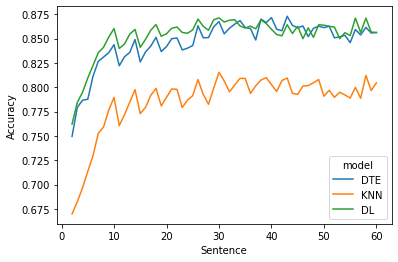

In [10]:
ax = sns.lineplot(data=df_all, x='Sentence', y='Accuracy', hue='model')

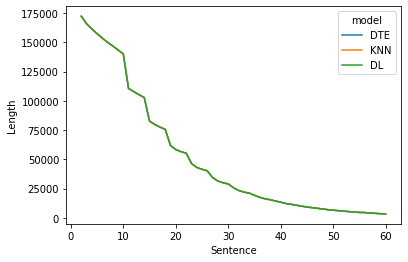

In [11]:
ax = sns.lineplot(data=df_all, x='Sentence', y='Length', hue='model')

Evaluate

In [12]:
df = metrics
grouped = df.groupby(df.group)
df_gender = grouped.get_group("gender")

df_gender = df_gender.drop(columns=['group', 'Accuracy'])
df_gender = pd.pivot_table(df_gender, values=["Precision","Recall","AUC","FPR"], index=["model", "Sentence"], columns=["subgroup"])
df_gender['PP'] = df_gender.Precision.girls-df_gender.Precision.boys
df_gender['EO'] = df_gender.Recall.boys-df_gender.Recall.girls
df_gender['SA'] = df_gender.AUC.girls-df_gender.AUC.boys
df_gender['PE'] = df_gender.FPR.boys-df_gender.FPR.girls
df_gender = df_gender.drop(columns=['AUC','Precision','Recall','FPR'])
df_gender.columns = df_gender.columns.droplevel(1)
df_gender = pd.pivot_table(df_gender, values=["PP","EO","SA","PE"], index=["Sentence"], columns=["model"])



In [13]:
#format result

def threshold001(v, props=''):
    return props if (v > 0.02) or (v < -0.02) else None

def threshold005(v, props=''):
    return props if (v > 0.05) or (v < -0.05) else None

def negativeValue(v, props=''):
    return props if (v < 0) else None

def showTable(df):
    styled = df.style.set_properties(color="black", align="right")\
        .set_properties(**{'background-color': 'white'})\
        .applymap(threshold001, props='color:orange;')\
        .applymap(threshold005, props='color:red;')\
        .applymap(negativeValue, props='font-weight:bold;')
    return styled

In [14]:
# s = showTable(df_gender)
# s

In [15]:
# writer = pd.ExcelWriter('df_gender.xlsx', engine='xlsxwriter')
# df_gender.to_excel(writer, sheet_name='Gender')
# writer.save()

In [16]:
test = df_gender
met = ['EO','PE','PP','SA']
fertig = pd.DataFrame()
for x in met:        
    a = 0
    for i in range(2, 10):
        a = a+test[x].DL[i]
    a = a/8
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '02-9',
            'Val': a
        }
    )
    fertig = pd.concat([fertig, temp])

    b = 0
    for i in range(10, 20):
        b = b+test[x].DL[i]
    b = b/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '10-19',
            'Val': b
        }
    )
    fertig = pd.concat([fertig, temp])

    c = 0
    for i in range(20, 30):
        c = c+test[x].DL[i]
    c = c/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '20-29',
            'Val': c
        }
    )
    fertig = pd.concat([fertig, temp])

    d = 0
    for i in range(30, 40):
        d = d+test[x].DL[i]
    d = d/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '30-39',
            'Val': d
        }
    )
    fertig = pd.concat([fertig, temp])

    e = 0
    for i in range(40, 50):
        e = e+test[x].DL[i]
    e = e/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '40-49',
            'Val': e
        }
    )
    fertig = pd.concat([fertig, temp])

    f = 0
    for i in range(50, 60):
        f = f+test[x].DL[i]
    f = f/10
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '50-60',
            'Val': f
        }
    )
    fertig = pd.concat([fertig, temp])

    

met = ['EO','PE','PP','SA']
for x in met:        
    a = 0
    for i in range(2, 10):
        a = a+test[x].DTE[i]
    a = a/8
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '02-9',
            'Val': a
        }
    )
    fertig = pd.concat([fertig, temp])

    b = 0
    for i in range(10, 20):
        b = b+test[x].DTE[i]
    b = b/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '10-19',
            'Val': b
        }
    )
    fertig = pd.concat([fertig, temp])

    c = 0
    for i in range(20, 30):
        c = c+test[x].DTE[i]
    c = c/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '20-29',
            'Val': c
        }
    )
    fertig = pd.concat([fertig, temp])

    d = 0
    for i in range(30, 40):
        d = d+test[x].DTE[i]
    d = d/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '30-39',
            'Val': d
        }
    )
    fertig = pd.concat([fertig, temp])

    e = 0
    for i in range(40, 50):
        e = e+test[x].DTE[i]
    e = e/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '40-49',
            'Val': e
        }
    )
    fertig = pd.concat([fertig, temp])

    f = 0
    for i in range(50, 60):
        f = f+test[x].DTE[i]
    f = f/10
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '50-60',
            'Val': f
        }
    )
    fertig = pd.concat([fertig, temp])

met = ['EO','PE','PP','SA']
for x in met:        
    a = 0
    for i in range(2, 10):
        a = a+test[x].KNN[i]
    a = a/8
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '02-9',
            'Val': a
        }
    )
    fertig = pd.concat([fertig, temp])

    b = 0
    for i in range(10, 20):
        b = b+test[x].KNN[i]
    b = b/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '10-19',
            'Val': b
        }
    )
    fertig = pd.concat([fertig, temp])

    c = 0
    for i in range(20, 30):
        c = c+test[x].KNN[i]
    c = c/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '20-29',
            'Val': c
        }
    )
    fertig = pd.concat([fertig, temp])

    d = 0
    for i in range(30, 40):
        d = d+test[x].KNN[i]
    d = d/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '30-39',
            'Val': d
        }
    )
    fertig = pd.concat([fertig, temp])

    e = 0
    for i in range(40, 50):
        e = e+test[x].KNN[i]
    e = e/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '40-49',
            'Val': e
        }
    )
    fertig = pd.concat([fertig, temp])

    f = 0
    for i in range(50, 60):
        f = f+test[x].KNN[i]
    f = f/10
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '50-60',
            'Val': f
        }
    )
    fertig = pd.concat([fertig, temp])




In [17]:
mean_table = pd.pivot_table(fertig, values=['Val'], index=['Range'], columns=['Metrik','Model'])
showTable(mean_table)